## TES 4 years dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [2]:
df_tesfour = pd.read_csv('../data/raw/TES 4 años.csv')
df_tesfour['Instrument Name'] = 'TES 4'
df_tesfour.head(10)

,Fecha,Último,Apertura,Máximo,Mínimo,% var.,Instrument Name
0,23.05.2022,10.300,10.300,10.300,10.300,-0.56%,TES 4
1,21.05.2022,10.358,10.358,10.358,10.358,0.00%,TES 4
2,20.05.2022,10.358,10.545,10.545,10.358,-2.65%,TES 4
3,19.05.2022,10.640,10.500,10.640,10.459,0.19%,TES 4
4,18.05.2022,10.620,10.719,10.719,10.616,-0.70%,TES 4
5,17.05.2022,10.695,10.562,10.695,10.562,1.26%,TES 4
6,16.05.2022,10.562,10.500,10.604,10.500,0.83%,TES 4
7,14.05.2022,10.475,10.475,10.475,10.475,0.00%,TES 4
8,13.05.2022,10.475,10.320,10.540,10.320,0.24%,TES 4
9,12.05.2022,10.450,10.449,10.450,10.365,0.77%,TES 4


Let us look at a first description of this dataset:

In [3]:
df_tesfour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fecha            4097 non-null   object 
 1   Último           4097 non-null   float64
 2   Apertura         4097 non-null   float64
 3   Máximo           4097 non-null   float64
 4   Mínimo           4097 non-null   float64
 5   % var.           4097 non-null   object 
 6   Instrument Name  4097 non-null   object 
dtypes: float64(4), object(3)
memory usage: 224.2+ KB


This dataset consists of 4097 rows and 5 columns (minus the identifier 'Instrument Name'), without missing values. Every row represents the interest rate for financing of Treasury Titles (TES) in a 4 year term. The columns provide basic information about these rates' behaviour.

It is possible that TES rates might have some influence on the change of ISA's stock values. To assess this claim, we need to perform an individual analysis of the TES (4 years) dataset. We will perform data cleaning beforehand.

In [4]:
# Replace hyphens by NANs
# df_tesfour = df_tesfour.replace('-', np.nan, regex=False)
# Correct typing for dates
df_tesfour['Fecha'] = pd.to_datetime(df_tesfour['Fecha'], format="%d.%m.%Y")
# The type for numerical variables is correct (float). 
# The 'Vol.' column contains abbreviations of numerical values, formatted as strings.
# In the original data, 'M' stands for millions and 'K' for thousands. We convert these to float using string methods.
def abbrev_to_float(string):
    # Convert to millions, ommit the last character. Before multiplication, commas must be removed
    if isinstance(string, str) == False:
        return string
    if string[-1] == 'M':
        return float(string[:-1].replace(',', '')) * 1000000
    # Convert to thousands
    if string[-1] == 'K':
        return float(string[:-1].replace(',', '')) * 1000
# df_tesfour['Vol.'] = df_tesfour['Vol.'].apply(abbrev_to_float)
# The entries in the percentage variation column are strings with an unnecesary '%' symbol
df_tesfour['% var.'] = df_tesfour['% var.'].str.replace('%', '', regex=False).astype(float)

In [5]:
df_tesfour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha            4097 non-null   datetime64[ns]
 1   Último           4097 non-null   float64       
 2   Apertura         4097 non-null   float64       
 3   Máximo           4097 non-null   float64       
 4   Mínimo           4097 non-null   float64       
 5   % var.           4097 non-null   float64       
 6   Instrument Name  4097 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 224.2+ KB


Let us add and rename some relevant columns. This is necessary in order to analyze our data thoroughly and creating date filters later on:

In [6]:
df_tesfour['Year'] = df_tesfour['Fecha'].dt.year
df_tesfour['Month'] = df_tesfour['Fecha'].dt.month
df_tesfour['Day'] = df_tesfour['Fecha'].dt.day
df_tesfour['Close Previous'] = df_tesfour['Último'].shift(-1)
# df_tesfour['V'] = ((df_tesfour['Último']-df_tesfour['Close previous'])/(df_tesfour['Último']))*100
df_tesfour = df_tesfour.rename(columns={'Fecha':'Date', 'Último':'Close', 'Apertura':'Open', 'Máximo':'High', 'Mínimo':'Low',
 'Vol.':'Volume', '% var.': 'Variation'})
df_tesfour

,Date,Close,Open,High,Low,Variation,Instrument Name,Year,Month,Day,Close Previous
0,2022-05-23,10.300,10.300,10.300,10.300,-0.56,TES 4,2022,5,23,10.358
1,2022-05-21,10.358,10.358,10.358,10.358,0.00,TES 4,2022,5,21,10.358
2,2022-05-20,10.358,10.545,10.545,10.358,-2.65,TES 4,2022,5,20,10.640
3,2022-05-19,10.640,10.500,10.640,10.459,0.19,TES 4,2022,5,19,10.620
4,2022-05-18,10.620,10.719,10.719,10.616,-0.70,TES 4,2022,5,18,10.695
...,...,...,...,...,...,...,...,...,...,...,...
4092,2007-01-18,8.964,0.000,0.000,0.000,-0.11,TES 4,2007,1,18,8.974
4093,2007-01-17,8.974,0.000,0.000,0.000,0.26,TES 4,2007,1,17,8.951
4094,2007-01-16,8.951,0.000,0.000,0.000,-0.32,TES 4,2007,1,16,8.980
4095,2007-01-15,8.980,8.980,8.980,8.980,-0.33,TES 4,2007,1,15,9.010


In [7]:
df_tesfour = df_tesfour[['Instrument Name', 'Date', 'Year', 'Month', 'Day', 'Open', 'High', 'Low',
 'Close', 'Close Previous', 'Variation']]
df_tesfour

,Instrument Name,Date,Year,Month,Day,Open,High,Low,Close,Close Previous,Variation
0,TES 4,2022-05-23,2022,5,23,10.300,10.300,10.300,10.300,10.358,-0.56
1,TES 4,2022-05-21,2022,5,21,10.358,10.358,10.358,10.358,10.358,0.00
2,TES 4,2022-05-20,2022,5,20,10.545,10.545,10.358,10.358,10.640,-2.65
3,TES 4,2022-05-19,2022,5,19,10.500,10.640,10.459,10.640,10.620,0.19
4,TES 4,2022-05-18,2022,5,18,10.719,10.719,10.616,10.620,10.695,-0.70
...,...,...,...,...,...,...,...,...,...,...,...
4092,TES 4,2007-01-18,2007,1,18,0.000,0.000,0.000,8.964,8.974,-0.11
4093,TES 4,2007-01-17,2007,1,17,0.000,0.000,0.000,8.974,8.951,0.26
4094,TES 4,2007-01-16,2007,1,16,0.000,0.000,0.000,8.951,8.980,-0.32
4095,TES 4,2007-01-15,2007,1,15,8.980,8.980,8.980,8.980,9.010,-0.33


In [8]:
# Save the clean dataframe into a csv file
df_tesfour.to_csv('../data/dev/TES 4 años.csv')

## Exploratory data analysis

Now we are in suitable conditions to obtain basic statistical descriptors:

In [9]:
df_tesfour.describe()

,Year,Month,Day,Open,High,Low,Close,Close Previous,Variation
count,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4097.000000,4096.000000,4097.000000
mean,2014.683427,6.481084,15.867220,32.300269,32.336208,32.261181,35.187725,35.193802,86.587196
std,4.308150,3.446748,8.730388,47.103336,47.147886,47.054228,45.213545,45.217392,386.801137
min,2007.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.125000,3.125000,-95.470000
25%,2011.000000,3.000000,8.000000,0.000000,0.000000,0.000000,5.300000,5.300000,-0.430000
50%,2015.000000,7.000000,16.000000,4.761000,4.770000,4.756000,6.930000,6.929500,0.000000
75%,2018.000000,9.000000,23.000000,98.466000,98.608000,98.356000,98.481000,98.487000,0.320000
max,2022.000000,12.000000,31.000000,115.745000,115.776000,115.558000,115.589000,115.589000,2104.640000


There seems to be high variability in the rate percentages (reaching even 2104%), although quartiles are near zero. This might indicate the presence of outliers.    

Let us provide visualizations for this dataset. We begin with the two most relevant variables regarding stock behaviour; closing prices (Último) and variation percentages (% var.).

Text(0.5, 1.0, 'TES 4 years')

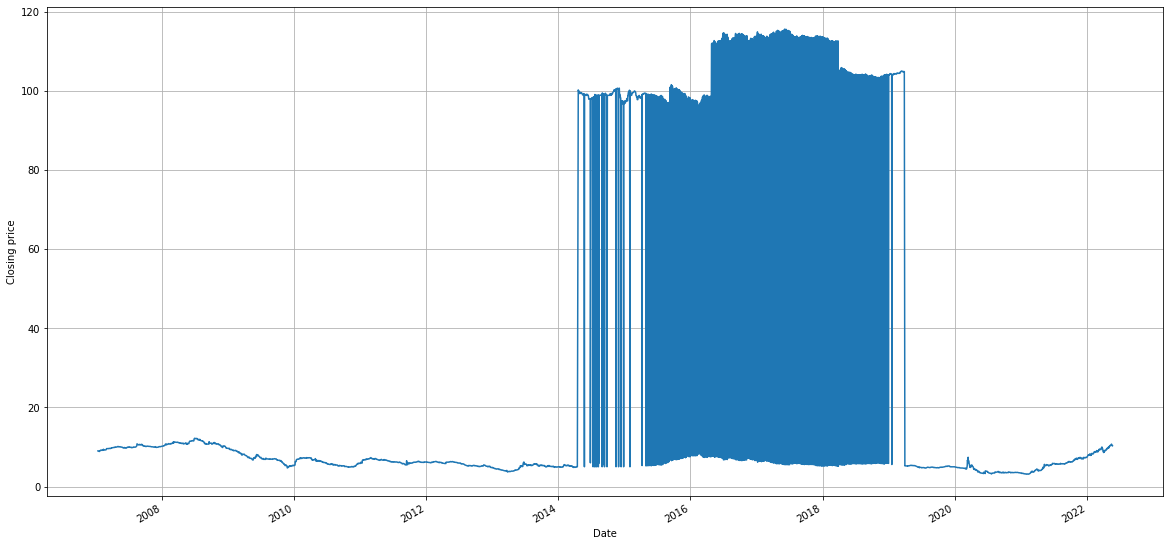

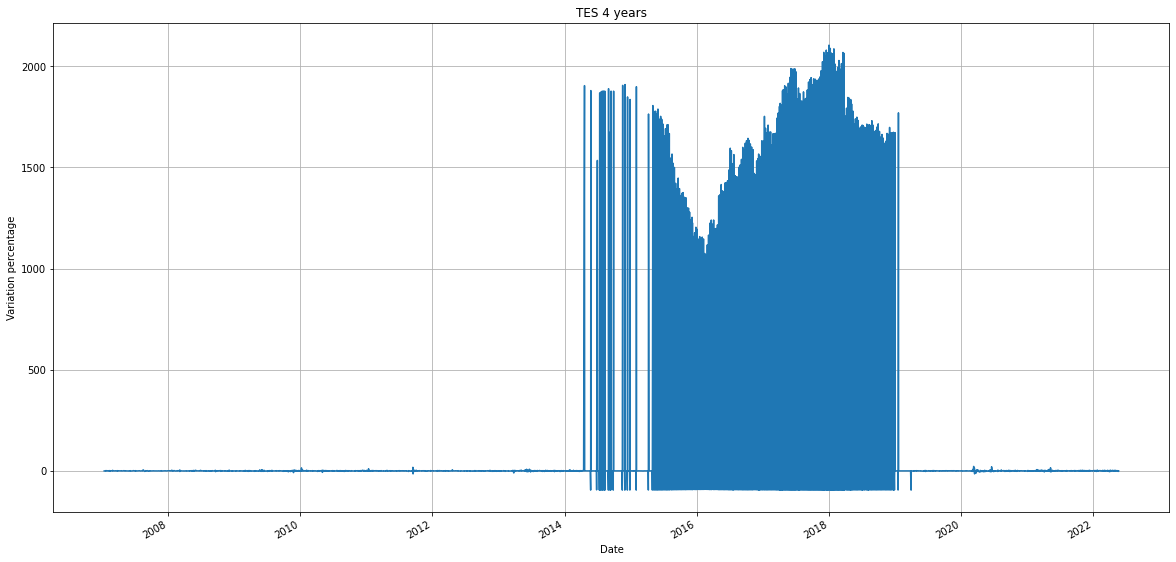

In [10]:
ax1 = df_tesfour.plot(use_index=True, x='Date', y='Close', style=['-'], figsize=(20,10), ylabel='Closing price', legend=False, grid=True)
ax2 = df_tesfour.plot(use_index=True, x='Date', y='Variation', style=['-'], figsize=(20, 10),
 ylabel='Variation percentage', legend=False, grid=True)

plt.title('TES 4 years')

0       10.300
1       10.358
2       10.358
3       10.640
4       10.620
         ...  
4092     8.964
4093     8.974
4094     8.951
4095     8.980
4096     9.010
Name: Close, Length: 4097, dtype: float64

The 2014-2019 period seems to be the most unstable in our dataset. Outside these dates, both the closing prices and variation percentages show low variability.

A dotted plot would allow us to visualize better the previous variations in these graphs. 

<Figure size 432x288 with 0 Axes>

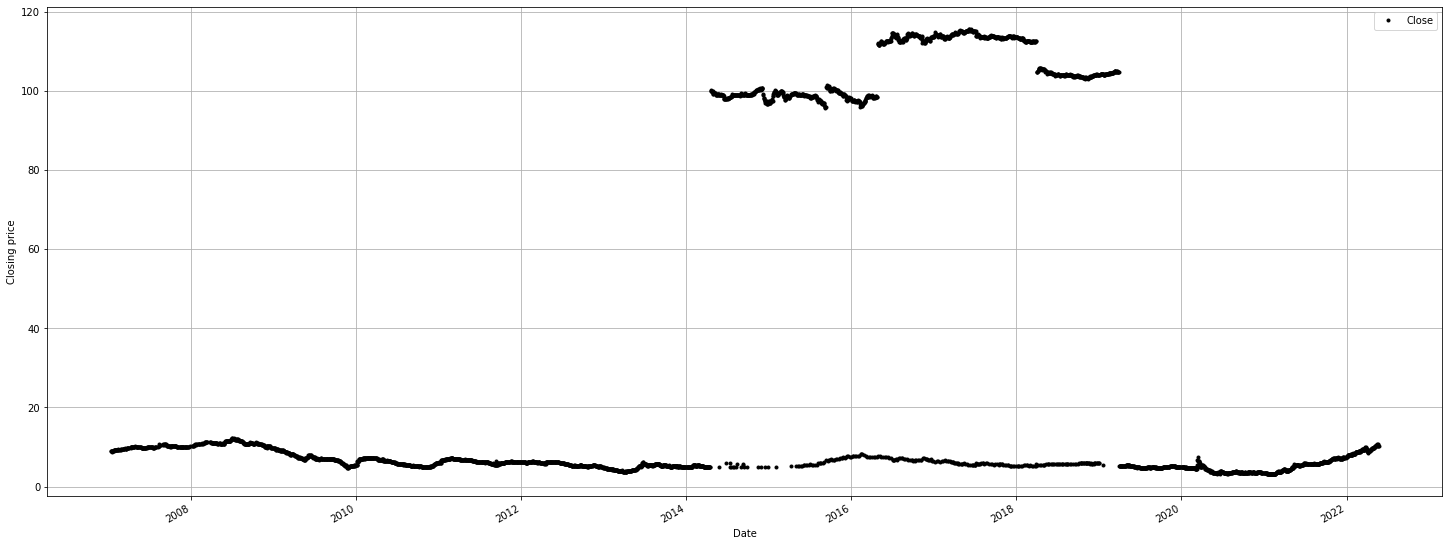

<Figure size 432x288 with 0 Axes>

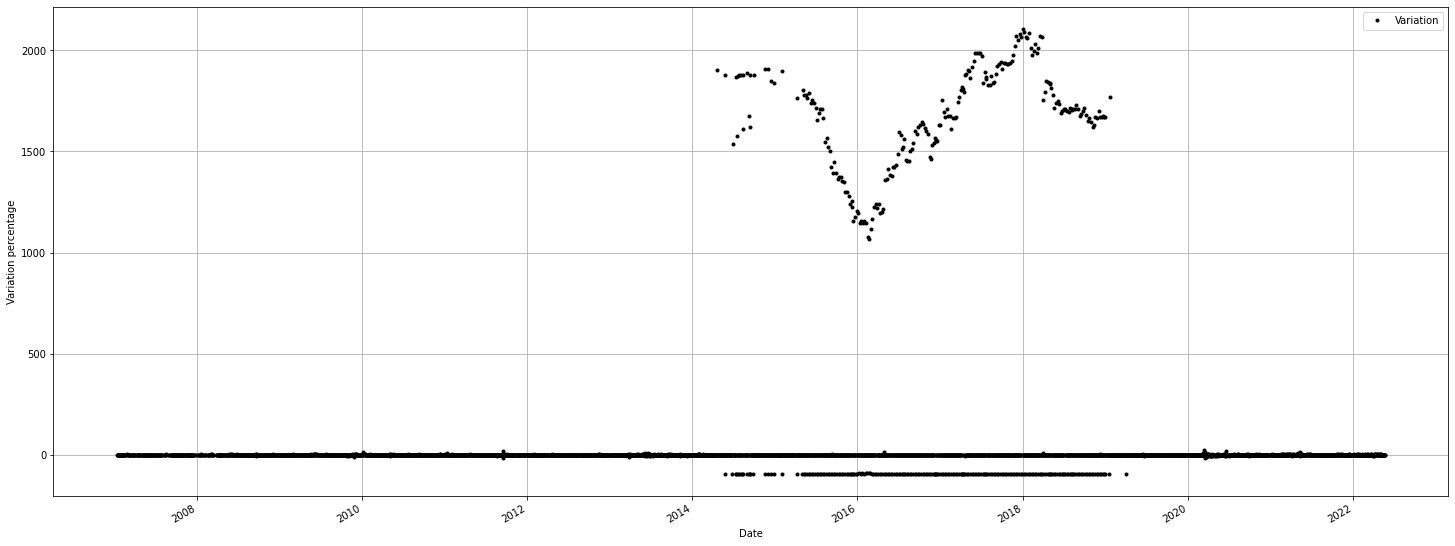

In [11]:
plt.figure()
ax3 = df_tesfour.plot(use_index=True, x='Date', y='Close', style='k.', grid=True, figsize=(25,10), ylabel='Closing price')
plt.figure()
ax4 = df_tesfour.plot(use_index=True, x='Date', y='Variation', style='k.', grid=True, figsize=(25,10), ylabel='Variation percentage')

Now, let us now examine the distributions of our variables via histograms:

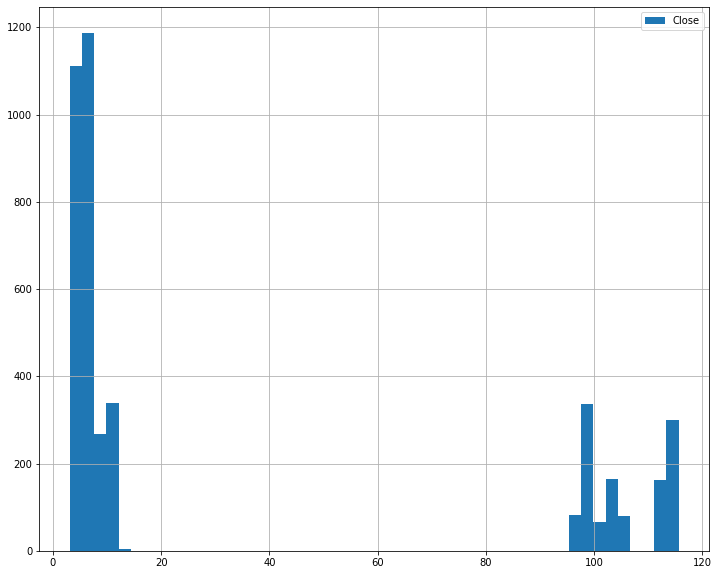

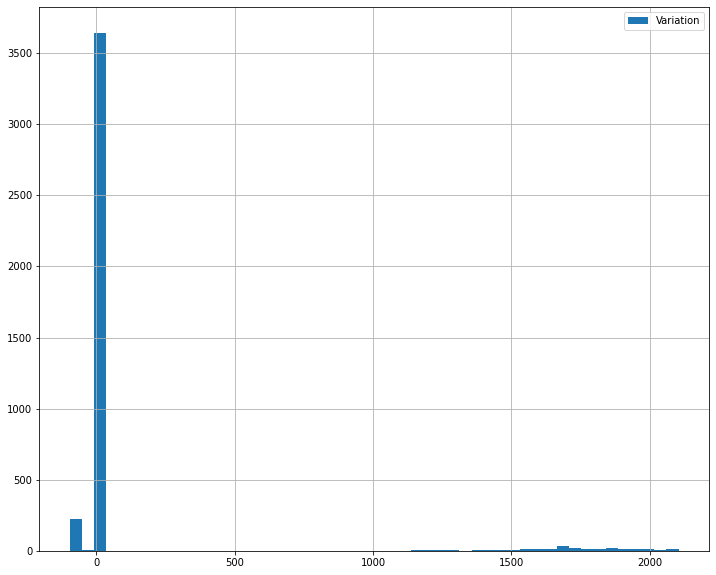

In [12]:
plt.figure()
ax5 = df_tesfour['Close'].hist(bins=50, figsize=(12,10), legend=True)

plt.figure()
ax6 = df_tesfour['Variation'].hist(bins=50, figsize=(12,10), legend=True)

The TES rates have remained in the 0 COP - 20 COP range. The remaining values appear in the 95-120 range and correspond to the extraneous period we visualized above.

Density plots, as an alternative to histograms, yield similar results:

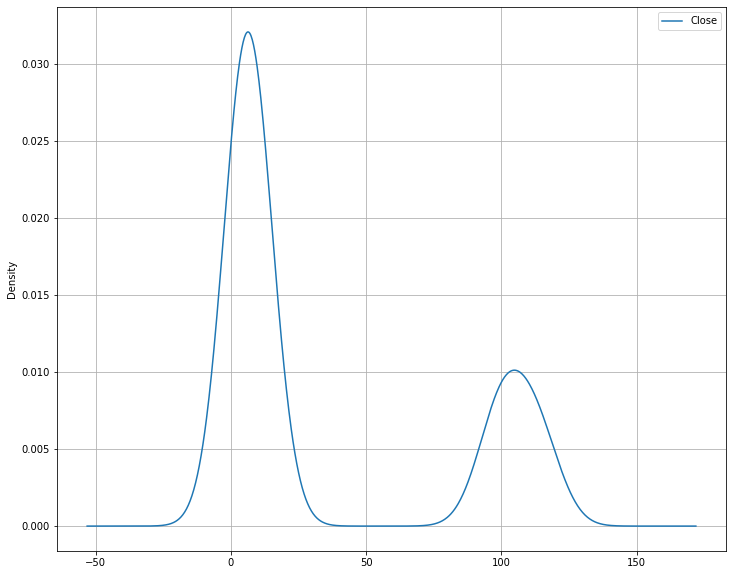

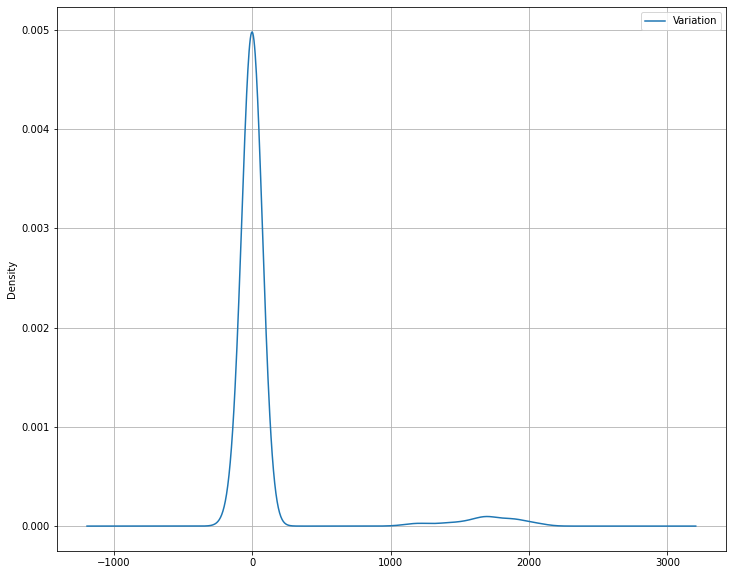

In [13]:
ax6 = df_tesfour['Close'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)
plt.figure()
ax7 = df_tesfour['Variation'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)

In order to reduce data variation, we showcase a moving average consisting of a window of 200 periods that presents the average evolution of the price based on the previous 200 data entries. This strategy does indeed reduce variations due to small peaks/valleys:

<ipython-input-14-244f034b8f45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tesfour['price_mean'] = df_tesfour['Close'].rolling(200, win_type=None).mean()
<ipython-input-14-244f034b8f45>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tesfour['perc_mean'] = df_tesfour['Variation'].rolling(200, win_type=None).mean()


<AxesSubplot:xlabel='Date', ylabel='Closing price'>

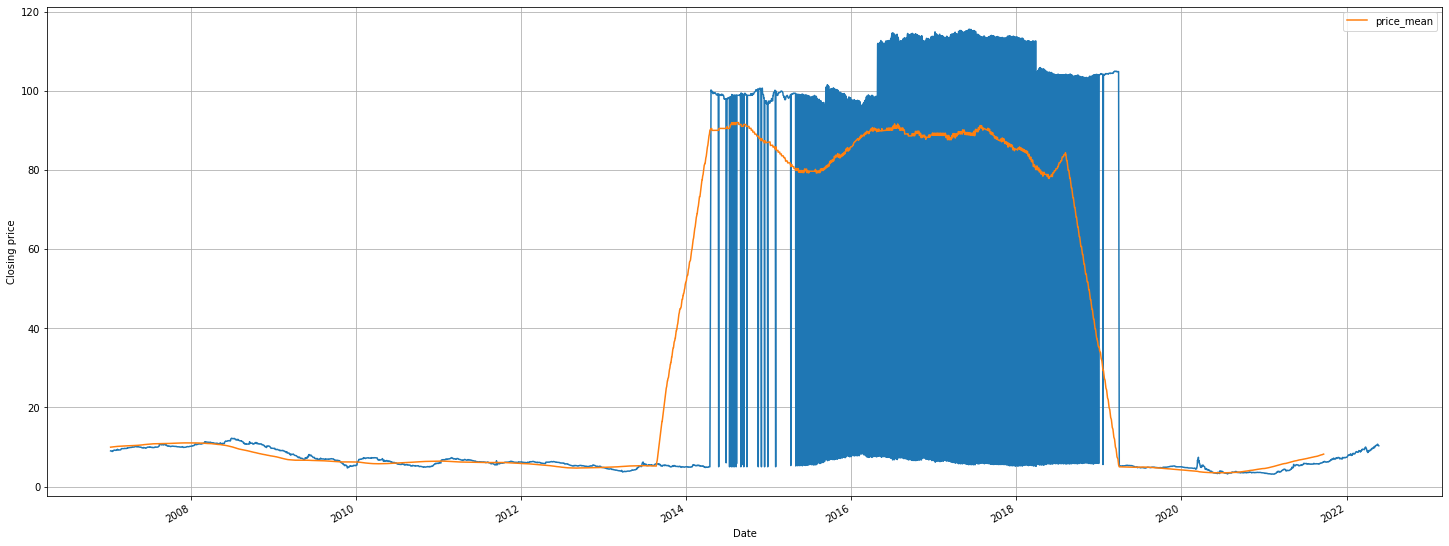

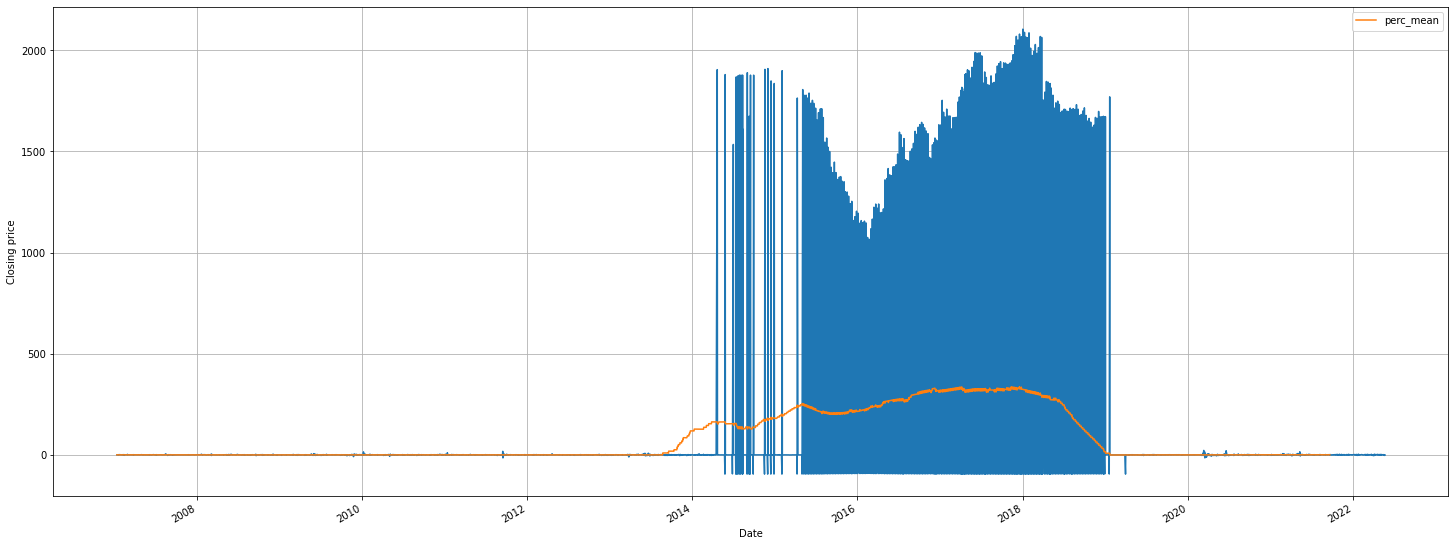

In [14]:
df_tesfour['price_mean'] = df_tesfour['Close'].rolling(200, win_type=None).mean()
ax11 = df_tesfour.plot(use_index=True, x='Date', y='Close', style=['-'], figsize=(25,10), ylabel='Closing price', legend=False, grid=True)
df_tesfour.plot(x='Date', y='price_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax11)

df_tesfour['perc_mean'] = df_tesfour['Variation'].rolling(200, win_type=None).mean()
ax22 = df_tesfour.plot(use_index=True, x='Date', y='Variation', style=['-'], figsize=(25,10), ylabel='Variation percentage',
 legend=False, grid=True)
df_tesfour.plot(x='Date', y='perc_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax22)

Let us now reduce variation by smoothing the data. Exponential smoothing allows noise to be smoothed without time shift implications, and thus is preferred

<ipython-input-15-03274a024db5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tesfour['Smooth'] = model.fittedvalues


<AxesSubplot:xlabel='Date', ylabel='Closing price'>

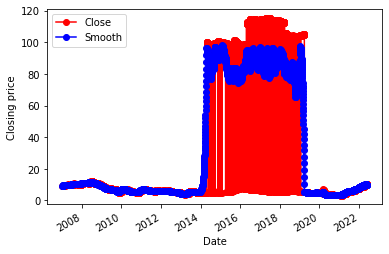

In [15]:
model = SimpleExpSmoothing(df_tesfour['Close']).fit(smoothing_level=.05, optimized=True)
df_tesfour['Smooth'] = model.fittedvalues
ax8 = df_tesfour.plot(x='Date', y='Close', marker='o', color='red', ylabel='Closing price')
df_tesfour.plot(x='Date', y='Smooth', marker='o', color='blue', ylabel='Closing price', ax=ax8)

A lag plot allows us to check for randomness. A lag plot with little data dispersion indicates that the data is not random, and instead follows a certain trend.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

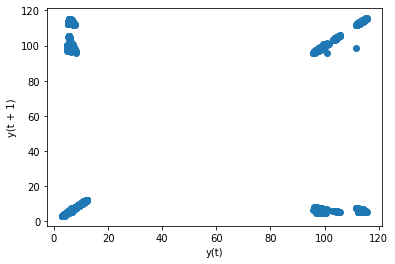

In [16]:
lag_plot(df_tesfour['Close'])

The absence of mainly random behavior can be verified via an autocorrelation plot. If the plot is distant from zero, then indeed randomness is not a main factor in this time series

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

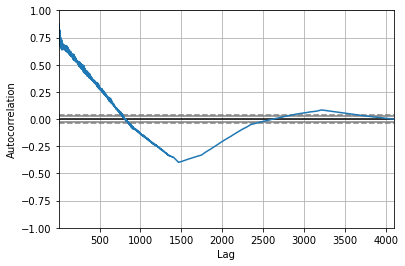

In [17]:
autocorrelation_plot(df_tesfour['Close'])

The lag plot does not show completely random points, and the autocorrelation plot is mostly distant from zero. Thus, this dataset does not seem to contain random data.

There is not a specific price volume to analyze the distribution. However,

## Yearly price and volume trend